In [1]:
ls /b "./excel"

data_gempa-21-30-januari2024.xlsx
laporan_data_1-10-januari2024.xlsx
laporan_data_31januari2024.xlsx
laporan_data_gempa_1des2024-10des2024.xlsx
laporan_data_gempa-11-20.xlsx


In [2]:
dt_1 = "excel/data_gempa-21-30-januari2024.xlsx"
dt_2 = "excel/laporan_data_1-10-januari2024.xlsx"
dt_3 = "excel/laporan_data_31januari2024.xlsx"

In [3]:
import pandas as pd

### Baca data excel

In [4]:
dt1 = pd.read_excel(dt_1)
dt2 = pd.read_excel(dt_2)
dt3 = pd.read_excel(dt_3)

### Gabung DataFrame

In [5]:
df = pd.concat([dt1, dt2, dt3], ignore_index=True)

### Rename kolom

In [6]:
df.columns = ['tanggal', 'lintang', 'bujur', 'kedalaman', 'magnitudo']

### Tambahkan 5 Data pertama

In [7]:
print(df.head())

               tanggal  lintang      bujur  kedalaman  magnitudo
0  2024-01-21 00:31:39    -8.90  123.80070       97.5       3.85
1  2024-01-21 01:10:56    -8.68  118.99418       98.6       2.82
2  2024-01-21 09:08:40   -10.38  120.20655       15.9       3.35
3  2024-01-21 09:38:47    -7.58  128.76584      157.9       4.95
4  2024-01-21 09:56:31     0.21  122.53956      126.0       3.23


### Catatan

> #### Jika Sheet lebih dari 1
> ``pd.read_excel("file.xlsx", sheet_name="Sheet1")``

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 647 entries, 0 to 646
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   tanggal    647 non-null    object 
 1   lintang    647 non-null    float64
 2   bujur      647 non-null    float64
 3   kedalaman  647 non-null    float64
 4   magnitudo  647 non-null    float64
dtypes: float64(4), object(1)
memory usage: 25.4+ KB


In [9]:
df['tanggal'] = pd.to_datetime(df['tanggal'])

In [10]:
# Contoh transformasi tanggal
df['tanggal'] = pd.to_datetime(df['tanggal'])
df['hari_ke'] = df['tanggal'].dt.dayofyear  # atau .dt.day jika Januari saja

In [19]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import os

In [15]:
# Pilih fitur
X = df[['hari_ke', 'lintang', 'bujur', 'magnitudo']]

# Standarisasi
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [16]:
df.shape

(647, 6)

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

# pakai 3D (lokasi + magnitudo)
X = df[['lintang', 'bujur', 'magnitudo']]

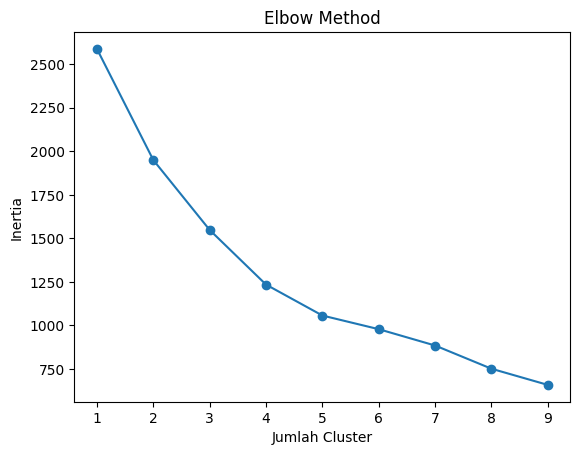

In [20]:
inertia = []
for k in range(1, 10):
    model = KMeans(n_clusters=k, random_state=42)
    os.environ["LOKY_MAX_CPU_COUNT"] = "4"
    model.fit(X_scaled)
    inertia.append(model.inertia_)

# Plot elbow
plt.plot(range(1, 10), inertia, marker='o')
plt.xlabel('Jumlah Cluster')
plt.ylabel('Inertia')
plt.title('Elbow Method')
plt.show()

In [21]:
kmeans = KMeans(n_clusters=3, random_state=42)
df['cluster'] = kmeans.fit_predict(X_scaled)

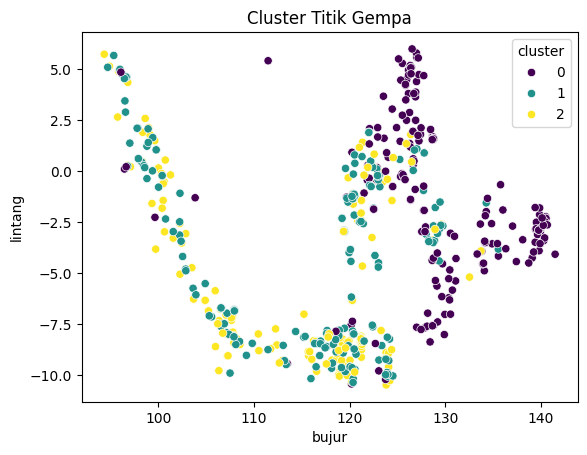

In [22]:
import seaborn as sns

sns.scatterplot(data=df, x='bujur', y='lintang', hue='cluster', palette='viridis')
plt.title('Cluster Titik Gempa')
plt.show()

In [23]:
df.groupby('cluster')[['hari_ke', 'lintang', 'bujur', 'magnitudo']].mean()


,hari_ke,lintang,bujur,magnitudo
cluster,,,,
0,11.577889,-1.215327,128.607805,4.020151
1,5.201970,-4.047833,115.152483,2.923448
2,26.195918,-5.881469,116.533433,3.169878


### Menambahkan label

In [24]:
def label_cluster(row):
    if row['cluster'] == 2:
        return 'kuat'
    elif row['cluster'] == 1:
        return 'sedang'
    else:
        return 'lemah'

df['kategori_gempa'] = df.apply(label_cluster, axis=1)

In [25]:
df.head()

,tanggal,lintang,bujur,kedalaman,magnitudo,hari_ke,cluster,kategori_gempa
0,2024-01-21 00:31:39,-8.90,123.80070,97.5,3.85,21,2,kuat
1,2024-01-21 01:10:56,-8.68,118.99418,98.6,2.82,21,2,kuat
2,2024-01-21 09:08:40,-10.38,120.20655,15.9,3.35,21,2,kuat
3,2024-01-21 09:38:47,-7.58,128.76584,157.9,4.95,21,0,lemah
4,2024-01-21 09:56:31,0.21,122.53956,126.0,3.23,21,2,kuat


In [26]:
# Tambah kategori berdasarkan rata-rata magnitudo
centroids = df.groupby('cluster')['magnitudo'].mean().sort_values()
label_map = {centroids.index[0]: 'lemah', centroids.index[1]: 'sedang', centroids.index[2]: 'kuat'}
df['kategori_gempa'] = df['cluster'].map(label_map)

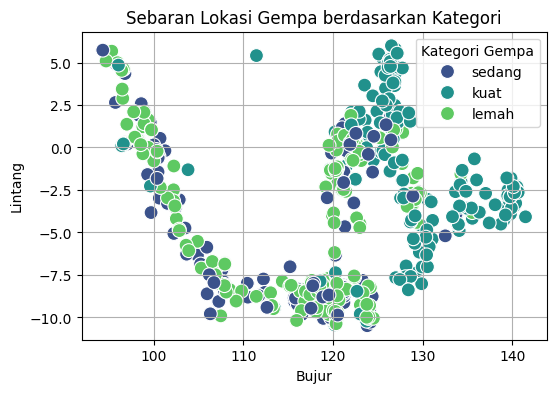

In [28]:
plt.figure(figsize=(6, 4))
sns.scatterplot(data=df, x='bujur', y='lintang', hue='kategori_gempa', palette='viridis', s=100)
plt.title('Sebaran Lokasi Gempa berdasarkan Kategori')
plt.xlabel('Bujur')
plt.ylabel('Lintang')
plt.legend(title='Kategori Gempa')
plt.grid(True)
plt.show()

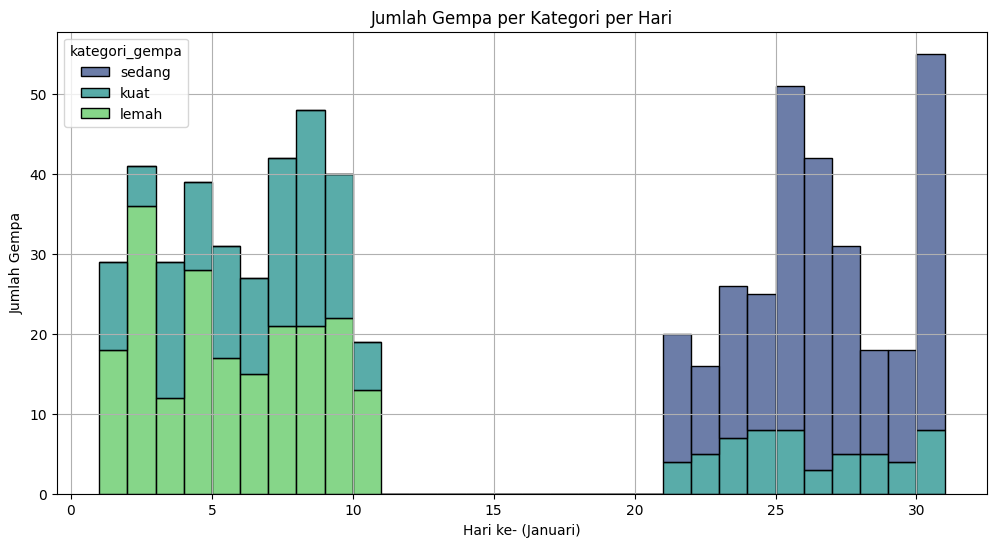

In [29]:
plt.figure(figsize=(12, 6))
sns.histplot(data=df, x='hari_ke', hue='kategori_gempa', multiple='stack', bins=30, palette='viridis')
plt.title('Jumlah Gempa per Kategori per Hari')
plt.xlabel('Hari ke- (Januari)')
plt.ylabel('Jumlah Gempa')
plt.grid(True)
plt.show()


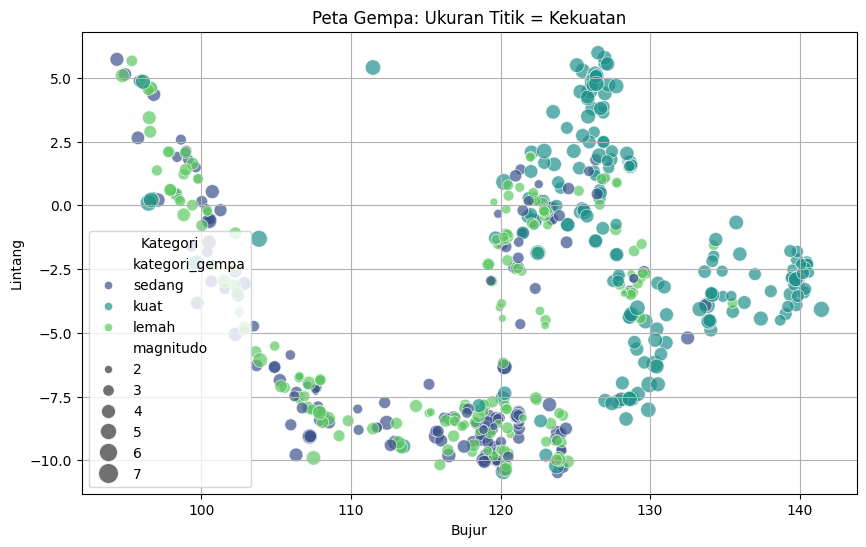

In [30]:
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df, x='bujur', y='lintang', size='magnitudo', hue='kategori_gempa',
                palette='viridis', sizes=(20, 200), alpha=0.7)
plt.title('Peta Gempa: Ukuran Titik = Kekuatan')
plt.xlabel('Bujur')
plt.ylabel('Lintang')
plt.legend(title='Kategori')
plt.grid(True)
plt.show()

In [ ]:
import os
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

inertia = []
K = range(1, 10)  # Uji 1–9 cluster
for k in K:
    km = KMeans(n_clusters=k, random_state=42)
    os.environ["LOKY_MAX_CPU_COUNT"] = "4"
    km.fit(X)
    inertia.append(km.inertia_)  # Semakin kecil, semakin padat cluster

# Plot Elbow
plt.figure(figsize=(6, 4))
plt.plot(K, inertia, 'bo-')
plt.xlabel('Jumlah Cluster (k)')
plt.ylabel('Inertia (SSE)')
plt.title('Metode Elbow untuk Menentukan k')
plt.grid(True)
plt.show()

### Kelompokan berdasarkan hasil visualisasi elbow (K=3)

## KLASIFIKASI

In [ ]:
def klasifikasi_magnitudo(m):
    if m < 4:
        return "Lemah"
    elif m < 6:
        return "Sedang"
    else:
        return "Besar"

# Terapkan ke DataFrame
df['class'] = df['magnitudo'].apply(klasifikasi_magnitudo)

In [ ]:
df.head()

In [ ]:
df.to_csv("data_gempa_berlabel.csv", index=False)